# Simulation of Options Prices

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import default_rng
from scipy.stats import norm
import time

In [15]:
m = int(1e4) # Number of replications (needs about 10^5 for stability)
n = 100 # Number of RVs Y generated for each process
mu = 0.05 # default return, equivalent to risk free rate
r = mu # Risk free rate
k = 130 # Default strike
sigma2 = 0.15 # Default volatility
S0 = 100 # Default starting price of stock
T = 1 # Default time until expiry, ie 1 period

## 1. Brownian Motion

Generate a sequence of n $Y_i$'s with mean 0, variance 1

We can generate a simulated Brownian Motion as follows:

$W(\frac{i}{n})=W(\frac{i-1}{n}) + \frac{Y_i}{\sqrt{n}}$

In [31]:
def bm(m=int(1e4),n=100, crn=None, vectorize=True):
    
    # Variance reduction using Common Random Numbers passed to the bm function.
    # Used when calculating for instance option values as underlying or other input varies
    # Not needed for simple demo of bm or gbm
    
    if crn is not None:
        m = crn.shape[0]
        n = crn.shape[1]
        Y = crn
    else:
        Y = np.random.normal(size=(m,n))
        
    W = np.zeros((m,n)) 

    if not vectorize:
        # (Keep W(0) <- 0)
        for i in range(m):
            for j in range(1,n):
                W[i,j] = W[i,j-1] + Y[i,j]/(n**0.5)
        return W
  
    # Vectorized:
    Y_cumsum = np.cumsum(Y, axis=1)
    W[:,1:] = W[:,:-1] + Y_cumsum[:,1:]/(n**0.5)
    
    
    return W

Elapsed: 0.06653809547424316


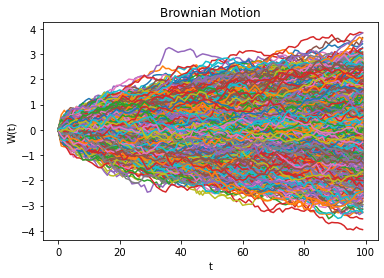

<Figure size 432x288 with 0 Axes>

In [17]:
start = time.time()
W = bm(m=int(1e4),n=100)
end = time.time()
print(f"Elapsed: {end-start}")
plt.plot(W.T)
plt.title("Brownian Motion")
plt.xlabel("t")
plt.ylabel("W(t)")
plt.show()
plt.clf()

## Geometric Brownian Motion

Geometric Brownian motion can be defined as the following continuous stochastic process:

$ S(t) = S(0)\exp\{(\mu-\frac{\sigma^2}{2})t + \sigma W(t)\} $

In [32]:
### Set simulation constants and initialize m*n array

def gbm(start_price=100, mu=0.05, sigma2 = 0.15, n=100, m=int(1e4), crn=None, vectorize=True):
    if crn is not None:
        m = crn.shape[0]
        n = crn.shape[1]
    
    W = bm(m=m,n=n,crn=crn)
    S = np.zeros((m,n))
    S[:,0] = start_price    
    
    if not vectorize:
        for i in range(m):
            for j in range(1,n):
                S[i,j] = start_price*(np.exp((mu-sigma2/2)*j/n +
                             sigma2**0.5*W[i,j] ))
        return S

    # J is an m*n matrix whose values are the column indices (and each row is the same)
    J = np.arange(n)[1:]
    S[:,1:] = start_price*(np.exp((mu-sigma2/2)*J/n + sigma2**0.5*W[:,1:]))

    return S
        

Elapsed: 0.07793474197387695


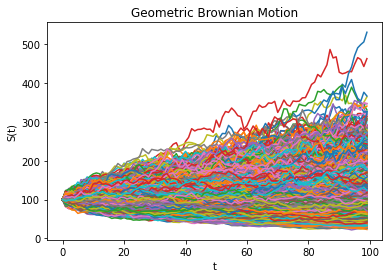

In [19]:
start = time.time()
S_ = gbm(start_price=100, mu=0.05, sigma2=0.15, m=int(1e4), n=100)
end = time.time()
print(f"Elapsed: {end-start}")

plt.clf()
plt.plot(S_.T)
plt.title("Geometric Brownian Motion")
plt.xlabel("t")
plt.ylabel("S(t)")
plt.show()

Can try varying mu and sigma2 and compare

# European Call - Monte Carlo Simulation

We can calculate the values of a call as follows:

$Price = e^{-rT} E[(S(T)-k]^+$ 

First lets calculate the $E[S(T)]$ by averaging over the last column of all the brownian motion runs above

In [33]:
def mc_eurocall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=int(1e4), n=100, T=1, crn = None, verbose=True):
    if crn is not None:
        m = crn.shape[0]
        n = crn.shape[1]

    S = gbm(start_price=underlying, mu=mu, sigma2= sigma2, m=m, n=n, crn=crn)
    payoff_col = round(T*n) - 1
    
    #Calculate the payout vector for all of the runs above
    #payout = S[:,-1]-k
    payout = S[:,payoff_col]-k
    #print(payoff_col)
    
    payout = np.array((payout,np.zeros(m)))
    payout = payout.max(axis=0)
    
    #The expected payout is the mean of all the payouts
    exp_payout = np.mean(payout)    
    European_Call_MC = np.exp(-r*T)*exp_payout

    if verbose:
        print(f"The expected payout is {round(exp_payout,4)}")
        print(f"The simulated option value is {round(European_Call_MC,4)}")
    
    return European_Call_MC
    
    

In [21]:
mc_eurocall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=int(1e5), n=100, verbose=True, T = 1)

The expected payout is 8.2188
The simulated option value is 7.8179


7.817949471772987

Calculate the payout vector for all of the runs above

The expected payout is the mean of all the payouts

Value of the **130 Strike European Call 100 days** with underlying stock price of **$100**, 100 days out from expiration 

(with a risk free rate of 0.05 and volatitlity = 0.15)

Comprison with Black-Scholes calculation:

In [22]:
# Black-Scholes for Call
r = mu
b = (r*T -sigma2*T/2 - np.log(k/S0))/(sigma2**0.5/T**0.5)


European_Call_BS = S0 * norm.cdf(b + sigma2**0.5*T**0.5)- k*np.exp(-r*T)*norm.cdf(b)
European_Call_BS
print(f"The Black-Scholes option value is {round(European_Call_BS,4)}")

The Black-Scholes option value is 7.8172


## Simulation assuming S(T) is lognormal

### ...TODO...

# Simulation of the Greeks

## Delta

The option delta is the change in the option value per change in the underlying. More formally, it is the partial derivative of an options value with respect to the underlying.

$$ \Delta = \frac{\partial V}{\partial S}$$

### Delta simulated at a point

Lets try to accurately simulate the delta at a specific point when the underlying stock is 100, continuing with our example above. We will compute the expected change in the option value for a $1 change in the underlying stock which should theoretically equal our delta 

In [93]:
def delta_mc_point(underlying=100, k=130, mu=0.05, simga2=0.15, m=int(1e5),n=100, verbose=False, num_reps=3,T =1,crn=None):
    # option price at point
    p1 = np.zeros(num_reps)
    for i in range(num_reps):
        p1[i] = mc_eurocall(underlying=underlying, k=130, mu=0.05, sigma2=0.15, m=m, n=100, T=T, crn=crn,verbose=False)
    p1 = p1.mean()
    
    #option price at point + small change in price (ie $1)
    p2 = np.zeros(num_reps)
    for i in range(num_reps):
        p2[i] = mc_eurocall(underlying=underlying+1, k=130, mu=0.05, sigma2=0.15, m=m, n=100, T=T, crn=crn, verbose=False)
    p2 = p2.mean()
    
    delta = (p2-p1)/1
    return round(delta,4)

In [94]:
m = int(1e5)
n = 100
delta_mc_ = delta_mc_point(crn=None, m=m, n=n)
delta_mc_VR = delta_mc_point(crn=np.random.normal(size=(m,n)))

In [95]:
#p2 = 8.072317188486938
#p1 = 7.740754997855431
#delta_MC = (p2-p1)/1
#delta_MC
print(f"The Monte Carlo simulated delta is {round(delta_mc_,4)} without variance reduction")
print(f"The Monte Carlo simulated delta is {round(delta_mc_VR,4)} with variance reduction")

The Monte Carlo simulated delta is 0.4029 without variance reduction
The Monte Carlo simulated delta is 0.3672 with variance reduction


In [96]:
# Black-Scholes calculation of the delta at this point
K = 130
d1 = (np.log(S0/K) + (r + sigma2/2)*1)/(sigma2**0.5*T**0.5)
d1
delta_BS = norm.cdf(d1)
delta_BS

print(f"The Black-Scholes calculation of delta is {round(delta_BS,4)}")

The Black-Scholes calculation of delta is 0.3614


### Delta simulated as underlying varies

Note that this was very computationally intensive. We will now sacrifice some accuracy in our calculations to compute delta over a whole range of underlying prices

In [58]:
x_ = 100 
fair_price = np.zeros(x_) # Array of option prices to be computed as underlying varies
print(f"Strike price {130}")
offset = 30
CRNs = None
for i in range(0,2*x_,2):
    fair_price[i//2] = mc_eurocall(underlying=offset+i, k=130, mu=0.05, sigma2=0.15, m=int(1e5)*3, n=100, crn=CRNs, verbose=False)
    #print(f"underlying {offset + i}, fair_price {fair_price[i]}")
    
    

Strike price 130


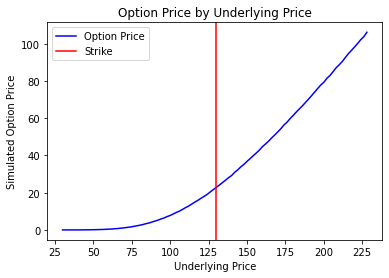

In [59]:
plt.plot([*range(30,230,2)],fair_price,color="blue",label="Option Price")
plt.title("Option Price by Underlying Price")
plt.ylabel("Simulated Option Price")
plt.xlabel("Underlying Price")
plt.axvline(K,color="red",label="Strike")
plt.legend()
plt.show()

Note that the **delta** of the call will be the **slope of the blue curve**. Theoretically the delta should converge to 0 when the option is far out of the money and 1 when the option is far in the money

Text(0, 0.5, 'Simulated Delta')

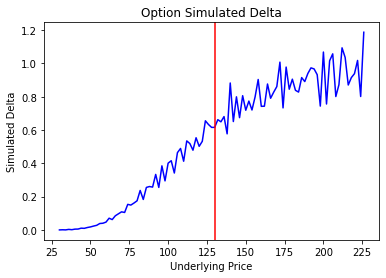

In [60]:
plt.title("Option Simulated Delta")
plt.plot([*range(30,230,2)[:-1]],(fair_price[1:] - fair_price[:-1])/2,color="blue")
plt.axvline(K,color="red",label="Strike")
plt.xlabel("Underlying Price")
plt.ylabel("Simulated Delta")

Now lets run the exact same simulation with variance reduction using CRNs

Strike price 130


Text(0, 0.5, 'Simulated Delta')

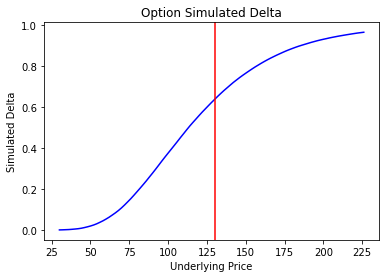

In [97]:
x_ = 100 
fair_price = np.zeros(x_) # Array of option prices to be computed as underlying varies
print(f"Strike price {130}")
offset = 30
CRNs = np.random.normal(size=(int(1e5),100))
for i in range(0,2*x_,2):
    fair_price[i//2] = mc_eurocall(underlying=offset+i, k=130, mu=0.05, sigma2=0.15, m=int(1e5)*3, n=100, crn=CRNs, verbose=False)
    #print(f"underlying {offset + i}, fair_price {fair_price[i]}")

plt.title("Option Simulated Delta")
plt.plot([*range(30,230,2)[:-1]],(fair_price[1:] - fair_price[:-1])/2,color="blue")
plt.axvline(K,color="red",label="Strike")
plt.xlabel("Underlying Price")
plt.ylabel("Simulated Delta")
    

## Gamma

### Gamma at a point

The gamma is the change in delta with respect to the underlying.

$$\Gamma = \frac{\partial \Delta}{\partial S}$$

Now lets simulate gamma (the change in delta) with respect to change in the underlying.
We will do this at a single point (underlying = 100)


(Note the cell below may take a few minutes to run)

In [ ]:
S0 = 100

In [ ]:
gamma_mc = (delta_mc(underlying=(S0+1),num_reps=1)-delta_mc(underlying=S0,num_reps=1))/1

In [ ]:
print(f"MonteCarlo Simulated gamma is {gamma_mc}")

In [ ]:
d1 = (np.log(S0/K) + (r + sigma2/2)*1)/(sigma2**0.5*T**0.5)

In [ ]:
gamma_bs = norm.pdf(d1)/(S0*sigma2**0.5*T**0.5)
gamma_bs
print(f"The Black-Scholes calculated gamma is {round(gamma_bs,4)}")

## Theta

The theta $\Theta$ is the time decay, or the rate at which the option loses value as time passes. The options value should comprise of 2 components, the intrinsic value and the time value. All else being equal, a $\Theta$ of -0.1 would signify that the option would lose value by $0.10 for each day that passes.

Let $V= Option Value, t= time$


$$\Theta = -\frac{\partial V}{\partial t}$$


### Theta at a point
Lets now simulate this with respect to our call option



In [ ]:
p1 = mc_eurocall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=3*int(1e6), n=100, T=0.99, verbose=True)

In [ ]:
p2 = mc_eurocall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=3*int(1e6), n=100, T=1, verbose=True)

In [ ]:
theta_mc = p1-p2
theta_mc
print(f"theta calculated via MonteCarlo Simulation {round(theta_mc,4)}")

In [ ]:
# Via BS_method:
T = 1

theta_bs = -S0*norm.pdf(d1)*sigma2**0.5/(2*T**0.5)
theta_bs/100

print(f"theta via Black Scholes: {theta_bs}")

### Theta as time passes

In [ ]:
# Still in progress

In [ ]:
# Theta over tiem
thetas = np.zeros(99)
for i in range(99):
    thetas[i] =mc_eurocall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=int(1e5), n=100, T=(i)/100+0.01, verbose=False) - mc_eurocall(underlying=100, k=130, mu=0.05, sigma2=0.15, m=int(1e5), n=100, T=(i/100+0.01), verbose=False)

In [ ]:
plt.plot(thetas[::-1])

## Black-Scholes calculation for European Call

In [ ]:
S0=100
k= K

In [ ]:
# Black-Scholes for Call


r = mu
b = (r*T -sigma2*T/2 - np.log(k/S0))/(sigma2**0.5/T**0.5)


European_Call_BS = S0 * norm.cdf(b + sigma2**0.5*T**0.5)- k*np.exp(-r*T)*norm.cdf(b)
European_Call_BS

## European Put

In [ ]:
payout = k-S[:,-1]
payout.shape

payout = np.array((payout,np.zeros(m)))
payout = payout.max(axis=0)

Once again, the expected payout is the mean of all the payouts

In [ ]:
exp_payout = np.mean(payout)
exp_payout

Value of the european `$130` put 100 days out from expiration with underlying at `$100`.

Note that we expect it to be much more valuable that the call as its **in the money (ITM) put** but **out-of-the money (OTM) call*

In [ ]:
European_Put = np.exp(-r*T)*exp_payout
European_Put

In [ ]:
exp_payout/European_Put

In [ ]:
# Black Scholes for call
BS = S0 * norm.cdf(b + sigma2**0.5*T**0.5)- k*np.exp(-r*T)*norm.cdf(b)

In [ ]:
BS

In [ ]:
norm.cdf(1.96)